In [5]:
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureMoleculeDriver, ElectronicStructureDriverType)
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import ParityMapper
from qiskit.opflow import TwoQubitReduction
from qiskit.utils import QuantumInstance
from qiskit import IBMQ, BasicAer, Aer
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP
from qiskit_nature.algorithms import (GroundStateEigensolver,
                                      NumPyMinimumEigensolverFactory)
from qiskit_nature.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms import VQE



def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

def get_qubit_op(coordinates):
    
    # Define Molecule
    molecule = Molecule(
        # Coordinates in Angstrom
        geometry=[
            ["H", [coordinates[0],coordinates[1],0]],
            ["H", [coordinates[2],coordinates[3],0]],
            ["H", [coordinates[4],coordinates[5],0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=1,
    )

    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF)

    # Get properties
    properties = driver.run()
    num_particles = (properties
                        .get_property("ParticleNumber")
                        .num_particles)
    num_spin_orbitals = int(properties
                            .get_property("ParticleNumber")
                            .num_spin_orbitals)
    
    # Define Problem, Use freeze core approximation, remove orbitals.
    problem = ElectronicStructureProblem(
        driver,
        [FreezeCoreTransformer(freeze_core=True)])

    second_q_ops = problem.second_q_ops()  # Get 2nd Quant OP
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles

    mapper = ParityMapper()  # Set Mapper
    hamiltonian = second_q_ops[0]  # Set Hamiltonian
    # Do two qubit reduction
    converter = QubitConverter(mapper,two_qubit_reduction=True)
    reducer = TwoQubitReduction(num_particles)
    qubit_op = converter.convert(hamiltonian)
    qubit_op = reducer.convert(qubit_op)

    return qubit_op, num_particles, num_spin_orbitals, problem, converter

def calc_ground_state(op,num_part,num_orb,problem,converter,simulator='qasm', shots=1028):

    
    if simulator == 'qasm':
        backend = Aer.get_backend('qasm_simulator') 
        quantum_instance = QuantumInstance(backend,shots=shots)
        optimizer = SPSA(maxiter=100)
    elif simulator == 'exact':
        backend = BasicAer.get_backend("statevector_simulator")
        quantum_instance = QuantumInstance(backend)
        optimizer = SPSA(maxiter=100)
    else:
        print('Error: simulator should be qasm or exact!')
 
    result = exact_solver(problem,converter)


    init_state = HartreeFock(num_orb, num_part, converter)
     
    var_form = UCCSD(converter,
                        num_part,
                        num_orb,
                        initial_state=init_state)

    vqe = VQE(var_form, optimizer, quantum_instance=quantum_instance) 
    vqe_result = vqe.compute_minimum_eigenvalue(op)
    min_eng = vqe_result.eigenvalue
    final_params = vqe_result.optimal_parameters 
    vqe_ground = vqe.ansatz.bind_parameters(final_params)  
    
    print('ground state energy: ',min_eng)
    
    return vqe_ground, min_eng

In [6]:
Ha = 4.36e-18
angst = 1.0e-10
dR = 0.02 #removed the angst, since coordinates are given in angst

from qiskit.opflow import I, X, Y, Z
from qiskit.opflow.primitive_ops import PauliOp
from qiskit.quantum_info import Pauli
#from hamiltonian import calc_ground_state, get_qubit_op
import numpy as np
from qiskit.utils import QuantumInstance
from qiskit.opflow import PauliExpectation, CircuitSampler, StateFn, CircuitStateFn
from qiskit import IBMQ, BasicAer, Aer

import time #to see which part of code takes the longest


def get_psi_0(coordinates, simulator='qasm',shots=1028):

    #get qubit operator corresponding to H(R)
    (qubit_op, num_part, num_orb, problem, converter) = get_qubit_op(coordinates)
    #get the ground state of H(R)
    psi_0,_ = calc_ground_state(qubit_op,num_part, num_orb, problem, converter, simulator,shots=shots)
    psi_0 = CircuitStateFn(psi_0)

    return psi_0

def calc_forces(coordinates, psi=None, simulator='qasm'):
    
    psi_0 = psi
    
    if (psi_0 == None):
        psi_0 = get_psi_0(coordinates, simulator)
        
    if simulator == 'exact':
        backend = Aer.get_backend('qasm_simulator') 
        q_instance = QuantumInstance(backend, shots=1028)
    elif simulator == "exact":
        backend = BasicAer.get_backend("statevector_simulator")
        q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    forces = []
    vars = []
    #loop over particles
    
    for i in range(len(coordinates)):

        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(np.split((coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:]),3))
    
        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
    
        #define desired observable (H_+ - H_-)/(2dR) = force  
        Obs = (qubit_op_plus-qubit_op_minus)
        Obs_var = Obs*Obs
        print("PRIMITIVE LIST")
        print(Obs_var.primitive.to_list())
        nuc = rep_eng_plus - rep_eng_minus
        #Obs_squared = Obs * Obs
       
        #get the expectation value <psi_0|O|psi_0>Ã‚Â¨
        
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        measurable_expression_var = StateFn(Obs_var, is_measurement=True).compose(psi_0)
        #measurable_expression_var =  StateFn(Obs_squared, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)
        expectation_var = PauliExpectation().convert(measurable_expression_var)
 
        #expectation_var = PauliExpectation().convert(measurable_expression)
        sampler = CircuitSampler(q_instance).convert(expectation)
        sampler_var = CircuitSampler(q_instance).convert(expectation_var)
        #sampler_var = CircuitSampler(q_instance).convert(expectation) 

        f = sampler.eval().real + nuc
        ff = sampler_var.eval().real + 2*sampler.eval().real*nuc +nuc**2 +(sampler.eval().real)**2
        print(ff)
        #print(sampler_var.eval())
        #variance = sampler_var.eval().real - f^2
        forces.append(f*Ha*(1/(2*dR*angst)))
        vars.append(ff*Ha*(1/(2*dR*angst)))
        # in the dimension of nN to avoid small values.
    
    return forces,vars


def calc_force_and_cov(coordinates, simulator = 'qasm', PauliSet = None, mode = 'full', shots = 1028):
    
    if simulator == 'exact':
            backend = Aer.get_backend('qasm_simulator') 
            q_instance = QuantumInstance(backend, shots=shots)
    elif simulator == "qasm":
            backend = BasicAer.get_backend("statevector_simulator")
            q_instance = QuantumInstance(backend)
    else:
        print('Error: simulator should be qasm or exact!')
        
    num_coord = len(coordinates)   
    
    start = time.time()
    psi_0 = get_psi_0(coordinates, simulator = simulator, shots=shots)
    end = time.time()
    
    time_psi_0 = end - start

    forces = np.zeros(num_coord)
    force_ops = []
    force_op_coeffs = [] # array with dictionaries containing Pauli coefficients
    coordinates = coordinates.tolist()
    
    
    start = time.time()
    #get force component operators and decomposition (without the 1/(2*dR) factor, for numerical reasons) 
    for i in range(num_coord):
        
        #get qubit operators coresponding to H+ (hamiltonian for atomic distances R + dR)
        (qubit_op_plus, num_part_plus, num_orb_plus, problem_plus, converter_plus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]+dR)]+coordinates[i+1:])
        #get qubit operators coresponding to H- (hamiltonian for atomic distances R - dR)
        (qubit_op_minus, num_part_minus, num_orb_minus, problem_minus, converter_minus) = get_qubit_op(coordinates[0:i]+[(coordinates[i]-dR)]+coordinates[i+1:])

        rep_eng_plus = problem_plus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        rep_eng_minus  = problem_minus.grouped_property_transformed.get_property("ElectronicEnergy").nuclear_repulsion_energy
        
        qubit_op_plus = qubit_op_plus + rep_eng_plus*(I^I^I^I) #TODO:number of I's needs to be changed according to number of qubits
        qubit_op_minus = qubit_op_minus + rep_eng_minus*(I^I^I^I)
        
       
        op =  -(qubit_op_plus - qubit_op_minus)
                    
        op_list = op.primitive.to_list() #list containing Pauli operators in support and corresponding coeffs
        
        #construct dict from list
        op_dict = {}
        for (PauliString,coeff) in op_list:

            if PauliString in op_dict:
                op_dict[PauliString] += coeff
            else:
                op_dict[PauliString] = coeff
                
        force_ops.append(op)
        force_op_coeffs.append(op_dict)
        
        if i == 0:  #we need two Pauli Ops to calculate the product and their support
            P1 = op
    
    
    if PauliSet == None:
        
        pauli_op_set = {'IIII'} #Could not initialize empty set for some reason
        # construct set of PauliOp products that we need to calculate

        for PauliString,coeff in force_op_coeffs[0].items():
            pauli_op_set.add(PauliString)

        #to get set of necessary PauliOp products:
        
            P_prod = P1@P1
            P_list = P_prod.primitive.to_list()

            for (PauliString,coeff) in P_list:
                pauli_op_set.add(PauliString)
                
    else: pauli_op_set = PauliSet
        
    end = time.time()
    
    time_pauli_ops = end - start
        

        # Now we calculate the expectation values of all the relevant PauliOps
    
    start = time.time()
    exp_dict = {} # dictionary with relevant expectation values
        
    for pauli_string in pauli_op_set:
            
        Obs = PauliOp(Pauli(pauli_string))
        measurable_expression = StateFn(Obs, is_measurement=True).compose(psi_0)
        expectation = PauliExpectation().convert(measurable_expression)  
        sampler = CircuitSampler(q_instance).convert(expectation) 
        E = sampler.eval().real
            
        exp_dict[pauli_string] = E
                
    for i in range(len(coordinates)):
        for pauli_op,coeff in force_op_coeffs[i].items():
            forces[i] += coeff.real*exp_dict[pauli_op]
            
    end = time.time()   
    time_calc_exp = end - start
    
    
    start = time.time()
    COV = np.zeros((num_coord,num_coord)) #force covariance matrix, without some multiplicative factors. 
        
    for i in range(num_coord):
        for j in range(i,num_coord):

            Pij = force_ops[i]@force_ops[j]
            Pij_list = Pij.primitive.to_list()

            #add product expectation <FiFj>
            for (pauli_string,coeff) in Pij_list:
                COV[i,j] += coeff.real*exp_dict[pauli_string]
                    #subtract <Fi><Fj>
            COV[i,j] -= forces[i]*forces[j]

            #since COV is symmetric
            if i < j:
                COV[j,i] = COV[i,j]
    end = time.time()
    
    time_cov = end - start

    #print(f'Time to: Calculate Ground State - {round(time_psi_0,2)}s, Get Pauli Ops - {round(time_pauli_ops,2)}s, Calculate Pauli Expectation Values - {round(time_calc_exp,2)}s, Calculate Covariance - {round(time_cov,2)}s')
    print(COV)
    return forces*Ha*(1/(2*dR*angst)),COV*(Ha*(1/(2*dR*angst)))**2

In [7]:
#from Quantech.verlet_integrator import distance
#from force import calc_force_and_cov
import numpy as np
from tqdm import tqdm #to show progress


#implementation of the explicit Euler integrator
femto = 1.0e-15
angst = 1.0e-10

def distance(coordinates1,coordinates2):
    return np.sqrt(np.power((coordinates1[0] - coordinates2[0]),2) + np.power((coordinates1[1] - coordinates2[1]),2))


def main():
    #mass of particle1 (H)
    mass_0 = 1.67e-27
    #mass of particle2 (H)
    mass_1 = 1.67e-27
    #mass of particle3 (H)
    mass_2 = 1.67e-27
    #time step of integrator
    dt = 0.2*femto
    #initial velocity of atoms
    v_init_0 = np.array([0,0])
    v_init_1 = np.array([0,0])
    v_init_2 = np.array([0,0])

    v_init = np.concatenate((v_init_0,v_init_1,v_init_2),axis=None)

    #distances between atoms
    d = 0.8

    #initial positions of atoms, arrangement = equilateral triangle
    init_pos0 = np.array([0,0])
    init_pos1 = np.array([d,0])
    init_pos2 = np.array([d/2,np.sqrt(3)/2*d])
    init_pos = np.concatenate((init_pos0,init_pos1,init_pos2),axis=None)

    #integrator timesteps
    times = np.arange(0*femto, 2.0*femto, dt)
    #coordinate array
    coords = [init_pos]
    force = []
    distance01 = [d]
    distance02 = [d]
    distance12 = [d]
    #temperature in ?? 
    #k_B*T in Joule
    k_b = 1.38065e-23
    T = 420
    k_T = k_b*T
        #delta factor
    delta = 0.1*dt
    #hold v_next
    v_next = None
    
    simulator = 'qasm'

    for time in tqdm(times, desc='Progress: '):
        
        r = coords[-1]
        
        (forces,COV) = calc_force_and_cov(coords[-1],simulator = simulator, shots = 2000)
        force.append(forces)
        
        if time == 0:

            v_next = v_init - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_init)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)
            

        else:

            v_next += - delta/(2*k_T*np.power(mass_0*mass_1*mass_2,1/3))*np.matmul(COV,v_next)*dt + dt*forces/mass_0
            
            r_next = (r*angst + dt*v_next)/angst

            #r_split = np.array_split(r_next,3)

            coords.append(r_next)

        dists = np.split(coords[-1],3)
        d01 = distance(dists[0],dists[1])
        print(d01)
        distance01.append(d01)
        d02 = distance(dists[0],dists[2])
        distance02.append(d02)
        d12 = distance(dists[1],dists[2])
        distance12.append(d12)
        
    return (distance01,distance02,distance12,times,force)    

In [8]:
import matplotlib.pyplot as plt
(distance01,distance02,distance12,times,force) = main()

Progress:   0%|          | 0/10 [00:00<?, ?it/s]

ground state energy:  (-3.164844815239448+0j)


Progress:  10%|█         | 1/10 [01:40<15:00, 100.03s/it]

[[ 8.61966305e-05 -8.61496513e-05 -8.61966305e-05 -8.61496513e-05
  -3.95556255e-15 -2.37786000e-04]
 [-8.61496513e-05  1.48016036e-03  8.61496513e-05  1.48016036e-03
  -1.15378570e-14  1.65888495e-03]
 [-8.61966305e-05  8.61496513e-05  8.61966305e-05  8.61496513e-05
   1.23932575e-14  2.37786000e-04]
 [-8.61496513e-05  1.48016036e-03  8.61496513e-05  1.48016036e-03
  -2.65607275e-15  1.65888495e-03]
 [-3.95556255e-15 -1.15378570e-14  1.23932575e-14 -2.65607275e-15
  -4.44089210e-16 -6.32366117e-17]
 [-2.37786000e-04  1.65888495e-03  2.37786000e-04  1.65888495e-03
  -6.32366117e-17  2.10492224e-03]]
0.8059539687389696
ground state energy:  (-3.180717388753279+0j)


Progress:  20%|██        | 2/10 [03:03<12:03, 90.46s/it] 

[[ 2.47501979e-05  4.31724078e-05 -2.47501979e-05  4.31724078e-05
   1.51049080e-14  1.02504730e-06]
 [ 4.31724078e-05  3.78100205e-04 -4.31724078e-05  3.78100205e-04
  -8.84280551e-16  3.09711401e-04]
 [-2.47501979e-05 -4.31724078e-05  2.47501979e-05 -4.31724078e-05
  -1.46608188e-14 -1.02504730e-06]
 [ 4.31724078e-05  3.78100205e-04 -4.31724078e-05  3.78100205e-04
   8.92076289e-16  3.09711401e-04]
 [ 1.51049080e-14 -8.84280551e-16 -1.46608188e-14  8.92076289e-16
   2.66453526e-15 -6.26435059e-18]
 [ 1.02504730e-06  3.09711401e-04 -1.02504730e-06  3.09711401e-04
  -6.26435059e-18  3.13187629e-04]]
0.8168384312512387
ground state energy:  (-3.0465543461351308+0j)


Progress:  30%|███       | 3/10 [04:27<10:11, 87.32s/it]

[[ 1.58325051e-04 -2.84841703e-04 -1.58325051e-04 -2.84841703e-04
   8.44047691e-15 -5.62057262e-04]
 [-2.84841703e-04  5.81058463e-03  2.84841703e-04  5.81058463e-03
  -1.02152314e-14  6.40471850e-03]
 [-1.58325051e-04  2.84841703e-04  1.58325051e-04  2.84841703e-04
  -4.88776323e-15  5.62057262e-04]
 [-2.84841703e-04  5.81058463e-03  2.84841703e-04  5.81058463e-03
  -6.66251771e-15  6.40471850e-03]
 [ 8.44047691e-15 -1.02152314e-14 -4.88776323e-15 -6.66251771e-15
   1.77635684e-15  1.32624661e-15]
 [-5.62057262e-04  6.40471850e-03  5.62057262e-04  6.40471850e-03
   1.32624661e-15  7.48598914e-03]]
0.8321494250165885
ground state energy:  (-2.679051484896706+0j)


Progress:  40%|████      | 4/10 [05:50<08:34, 85.70s/it]

[[ 3.19158117e-04  1.14648797e-03 -3.19158117e-04  1.14648797e-03
   2.49067951e-15  6.11170180e-04]
 [ 1.14648797e-03  1.42706783e-02 -1.14648797e-03  1.42706783e-02
   5.25572453e-15  1.25375355e-02]
 [-3.19158117e-04 -1.14648797e-03  3.19158117e-04 -1.14648797e-03
  -6.93157161e-15 -6.11170180e-04]
 [ 1.14648797e-03  1.42706783e-02 -1.14648797e-03  1.42706783e-02
   9.69661663e-15  1.25375355e-02]
 [ 2.49067951e-15  5.25572453e-15 -6.93157161e-15  9.69661663e-15
   4.44089210e-16 -1.11191891e-15]
 [ 6.11170180e-04  1.25375355e-02 -6.11170180e-04  1.25375355e-02
  -1.11191891e-15  1.17060638e-02]]
0.8512418514444783
ground state energy:  (-2.8873766304345168+0j)


Progress:  50%|█████     | 5/10 [07:11<07:00, 84.14s/it]

[[ 1.93977761e-04  5.36918527e-04 -1.93977761e-04  5.36918527e-04
   3.68621533e-15  2.05031495e-04]
 [ 5.36918527e-04  4.76962415e-03 -5.36918527e-04  4.76962415e-03
   8.69197927e-15  3.88159397e-03]
 [-1.93977761e-04 -5.36918527e-04  1.93977761e-04 -5.36918527e-04
  -4.13030454e-15 -2.05031495e-04]
 [ 5.36918527e-04  4.76962415e-03 -5.36918527e-04  4.76962415e-03
   3.80699796e-15  3.88159397e-03]
 [ 3.68621533e-15  8.69197927e-15 -4.13030454e-15  3.80699796e-15
   7.54951657e-15  9.12894731e-16]
 [ 2.05031495e-04  3.88159397e-03 -2.05031495e-04  3.88159397e-03
   9.12894731e-16  3.56183295e-03]]
0.8779144910804529
ground state energy:  (-2.9939007802317095+0j)


Progress:  60%|██████    | 6/10 [08:34<05:34, 83.71s/it]

[[ 9.72127127e-05  2.43705943e-05 -9.72127127e-05  2.43705943e-05
  -9.33892966e-15 -1.44019044e-04]
 [ 2.43705943e-05  2.23955867e-03 -2.43705943e-05  2.23955867e-03
  -2.04334149e-14  2.23088475e-03]
 [-9.72127127e-05 -2.43705943e-05  9.72127127e-05 -2.43705943e-05
   1.37798218e-14  1.44019044e-04]
 [ 2.43705943e-05  2.23955867e-03 -2.43705943e-05  2.23955867e-03
  -1.86570580e-14  2.23088475e-03]
 [-9.33892966e-15 -2.04334149e-14  1.37798218e-14 -1.86570580e-14
   6.66133815e-15 -5.75585092e-15]
 [-1.44019044e-04  2.23088475e-03  1.44019044e-04  2.23088475e-03
  -5.75585092e-15  2.51442709e-03]]
0.906175697726241
ground state energy:  (-2.4222038233944065+0j)


Progress:  70%|███████   | 7/10 [09:58<04:10, 83.55s/it]

[[ 1.16470522e-04 -8.89751562e-04 -1.16470522e-04 -8.89751562e-04
   2.59499996e-15 -1.09138548e-03]
 [-8.89751562e-04  2.38040710e-02  8.89751562e-04  2.38040710e-02
  -9.48838999e-15  2.54214654e-02]
 [-1.16470522e-04  8.89751562e-04  1.16470522e-04  8.89751562e-04
  -6.59180285e-15  1.09138548e-03]
 [-8.89751562e-04  2.38040710e-02  8.89751562e-04  2.38040710e-02
  -9.48838999e-15  2.54214654e-02]
 [ 2.59499996e-15 -9.48838999e-15 -6.59180285e-15 -9.48838999e-15
   3.99680289e-15 -1.09956064e-14]
 [-1.09138548e-03  2.54214654e-02  1.09138548e-03  2.54214654e-02
  -1.09956064e-14  2.73891034e-02]]
0.9280676391463158
ground state energy:  (-2.9547564482085886+0j)


Progress:  80%|████████  | 8/10 [11:20<02:46, 83.16s/it]

[[ 4.10441349e-05 -7.17161796e-05 -4.10441349e-05 -7.17161796e-05
   5.60825377e-15 -1.42464382e-04]
 [-7.17161796e-05  1.00169176e-03  7.17161797e-05  1.00169176e-03
  -2.85447024e-15  1.12743647e-03]
 [-4.10441349e-05  7.17161797e-05  4.10441349e-05  7.17161796e-05
  -6.05234298e-15  1.42464382e-04]
 [-7.17161796e-05  1.00169176e-03  7.17161796e-05  1.00169176e-03
  -4.18673787e-15  1.12743647e-03]
 [ 5.60825377e-15 -2.85447024e-15 -6.05234298e-15 -4.18673787e-15
   1.77635684e-15 -6.00152876e-15]
 [-1.42464382e-04  1.12743647e-03  1.42464382e-04  1.12743647e-03
  -6.00152876e-15  1.37516079e-03]]
0.9725736640800761
ground state energy:  (-2.8920236556426717+0j)


Progress:  90%|█████████ | 9/10 [12:41<01:22, 82.52s/it]

[[ 1.68576017e-05 -8.28713243e-06 -1.68576016e-05 -8.28713251e-06
  -7.30474960e-15 -3.71159156e-05]
 [-8.28713243e-06  4.40186628e-04  8.28713243e-06  4.40186630e-04
  -3.14860343e-14  4.54880251e-04]
 [-1.68576016e-05  8.28713243e-06  1.68576016e-05  8.28713251e-06
   1.61865338e-14  3.71159155e-05]
 [-8.28713251e-06  4.40186630e-04  8.28713251e-06  4.40186631e-04
  -3.85914616e-14  4.54880252e-04]
 [-7.30474960e-15 -3.14860343e-14  1.61865338e-14 -3.85914616e-14
  -7.54951657e-15 -1.01369715e-14]
 [-3.71159156e-05  4.54880251e-04  3.71159155e-05  4.54880252e-04
  -1.01369715e-14  5.18882283e-04]]
1.0173042521971551
ground state energy:  (-2.8203514403046204+0j)


Progress: 100%|██████████| 10/10 [14:04<00:00, 84.49s/it]

[[ 1.11686546e-05  4.86949796e-06 -1.11686546e-05  4.86949791e-06
  -1.64162314e-14 -1.41522865e-05]
 [ 4.86949796e-06  3.31025971e-04 -4.86949794e-06  3.31025973e-04
  -5.51751774e-14  3.24587542e-04]
 [-1.11686546e-05 -4.86949794e-06  1.11686546e-05 -4.86949789e-06
   1.73044098e-14  1.41522865e-05]
 [ 4.86949791e-06  3.31025973e-04 -4.86949789e-06  3.31025974e-04
  -5.73956235e-14  3.24587543e-04]
 [-1.64162314e-14 -5.51751774e-14  1.73044098e-14 -5.73956235e-14
  -2.22044605e-15 -2.83396889e-14]
 [-1.41522865e-05  3.24587542e-04  1.41522865e-05  3.24587543e-04
  -2.83396889e-14  3.50561677e-04]]
1.0609221641098046


(10, 6)


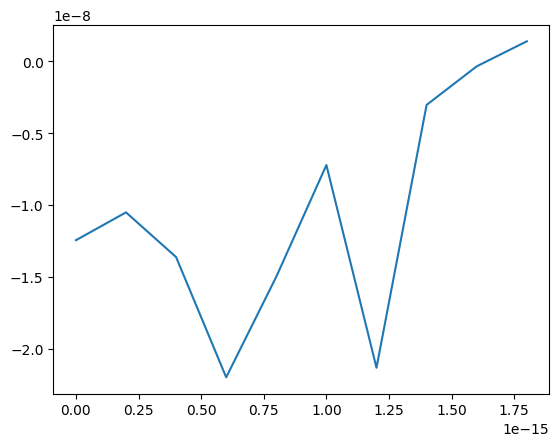

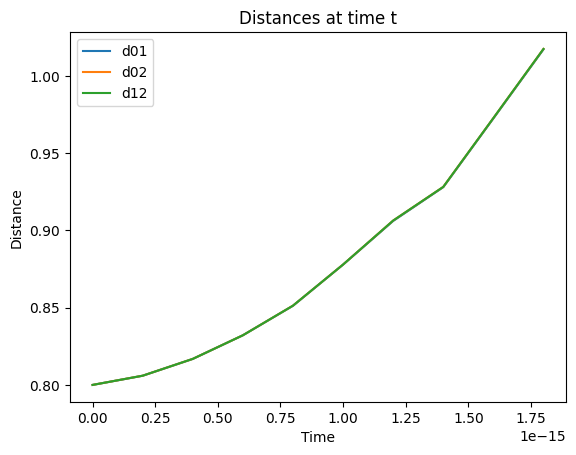

In [15]:
np_distance01 = np.array(distance01)
np_distance02 = np.array(distance02)
np_distance12 = np.array(distance12)
np_force = np.array(force)
print(np_force.shape)

plt.plot(times,np_force[:,0], label = 'force')
plt.show()
plt.plot(times,np_distance01[:-1],label = 'd01')
plt.plot(times,np_distance02[:-1],label = 'd02')
plt.plot(times,np_distance12[:-1],label = 'd12')
plt.title('Distances at time t')
plt.xlabel('Time')
plt.ylabel('Distance')
plt.legend()
plt.show()